In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read_csv("players.csv")|>
    select(-hashedEmail, -name, -gender)|>
    drop_na(Age, played_hours)

head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,Age
<chr>,<lgl>,<dbl>,<dbl>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
Amateur,TRUE,0.7,21
Regular,TRUE,0.1,21
Amateur,TRUE,0.0,17


In [3]:
players_data$experience <- factor(players_data$experience,
                             levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"),
                             labels = c(1, 2, 3, 4, 5))

head(players_data)

experience,subscribe,played_hours,Age
<fct>,<lgl>,<dbl>,<dbl>
5,TRUE,30.3,9
4,TRUE,3.8,17
4,FALSE,0.0,17
2,TRUE,0.7,21
3,TRUE,0.1,21
2,TRUE,0.0,17


In [4]:
players <- players_data |>
    mutate(experience = as.numeric(experience)) |>
    mutate(subscribe = as_factor(subscribe))

head(players)

experience,subscribe,played_hours,Age
<dbl>,<fct>,<dbl>,<dbl>
5,TRUE,30.3,9
4,TRUE,3.8,17
4,FALSE,0.0,17
2,TRUE,0.7,21
3,TRUE,0.1,21
2,TRUE,0.0,17


In [5]:
averages <- players|>
    summarize(avg_hrs = mean(played_hours, na.rm = TRUE), avg_age = mean(Age, na.rm = TRUE), avg_exp = mean(experience, na.rm = TRUE))
averages

avg_hrs,avg_age,avg_exp
<dbl>,<dbl>,<dbl>
5.904639,21.13918,2.695876


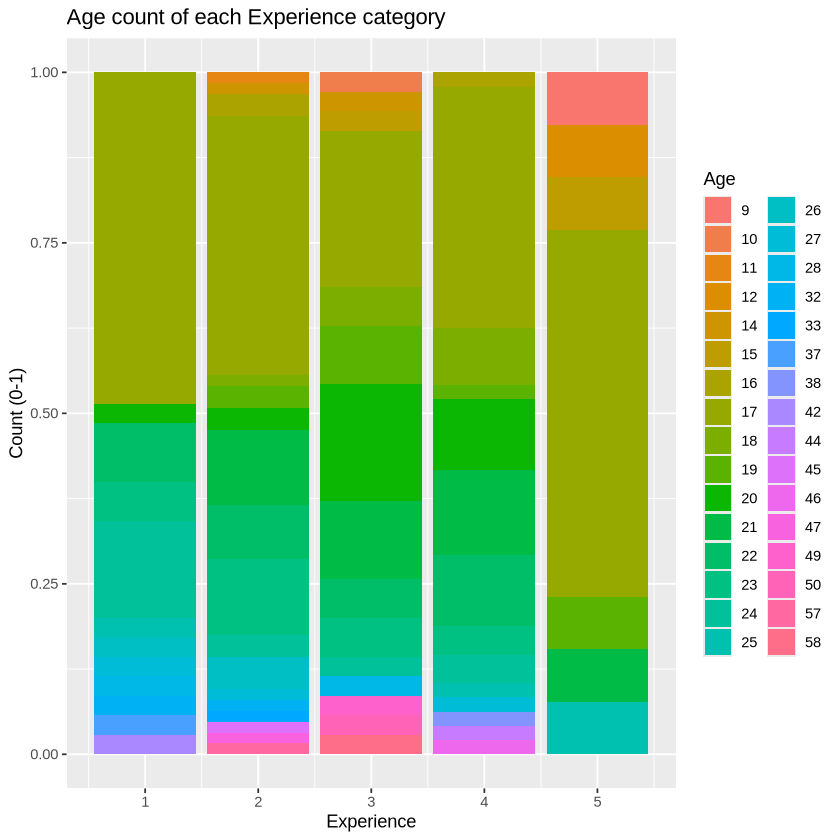

In [6]:
age_groups <- players |> 
    arrange(Age) |> 
    mutate(Age = as_factor(Age)) |>
    count(experience, Age)

age_exp_plot <- ggplot(age_groups, aes(x = experience, y = n, fill = Age)) + 
    geom_bar(stat = "identity", position = "fill") + 
    labs(x = "Experience", y = "Count (0-1)", fill = "Age", title = "Age count of each Experience category")
age_exp_plot

The bar plot above shows the age counts of players in each experience category. Each experience value is labelled as follows: 1 = Beginner, 2 = Amateur, 3 = Regular, 4 = Veteran, 5 = Pro. This bar plot helps visualize if there are any significant relationships between age and the experience level of the player (ie. if a certain age occupies more of an experience level).  

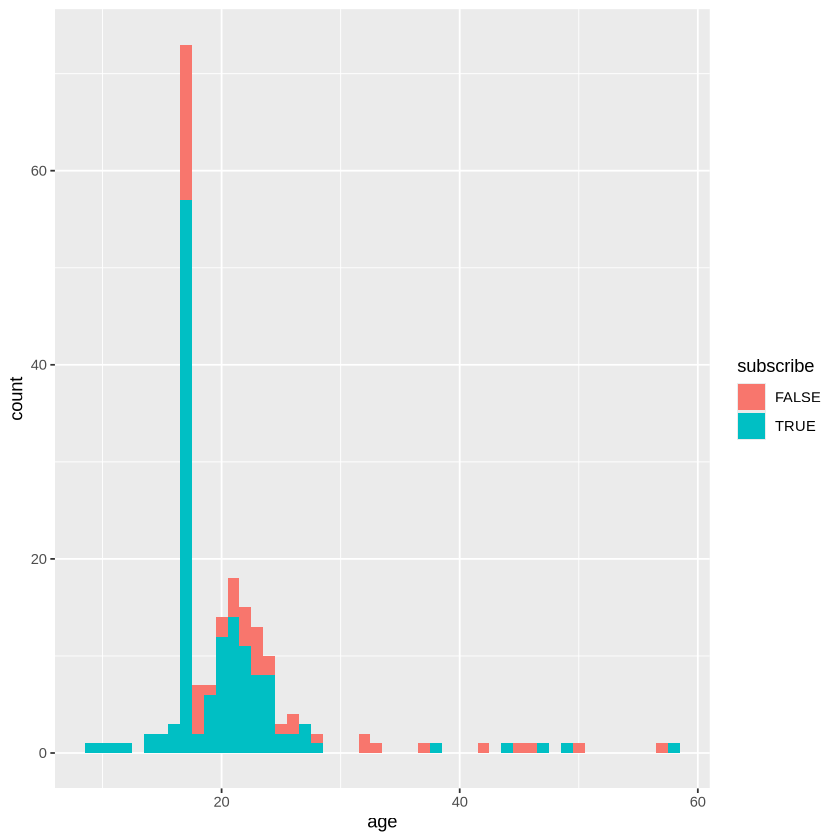

In [7]:
plot1 <- players|>
    ggplot(aes(x = Age, fill = subscribe))+
    geom_histogram(binwidth = 1)+
    labs(fill = "subscribe", x = "age")
plot1

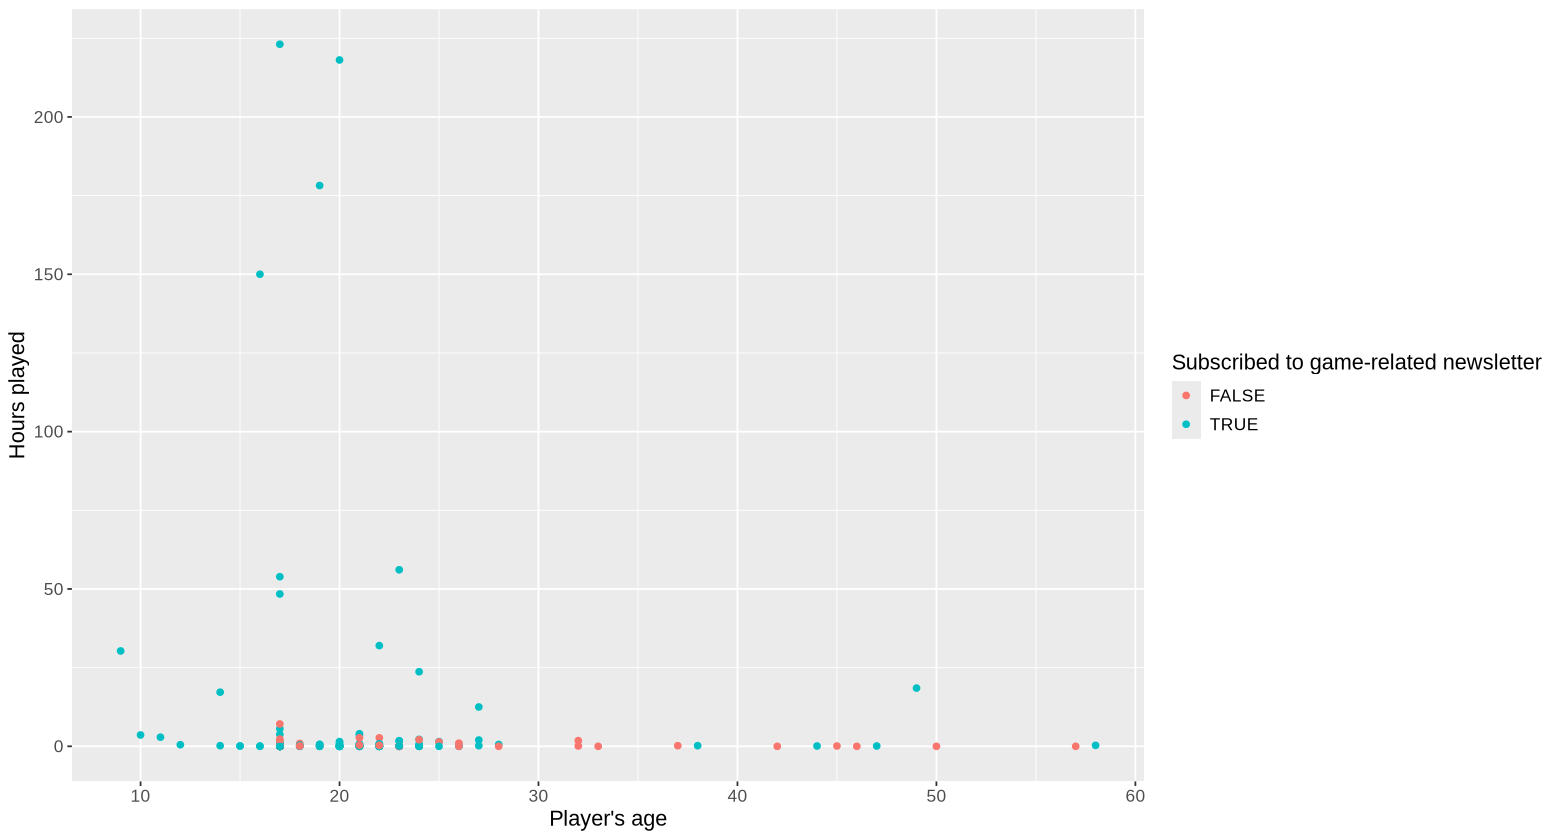

In [8]:
options(repr.plot.width = 13)

exploratory_plot <- players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = "Player's age", y = "Hours played", color = "Subscribed to game-related newsletter") +
    theme(text = element_text(size = 13))

exploratory_plot

The scatterplot above shows hours of the video game played vs the player's age. The colour of a dot (blue = subscribed, orange = not subscribed) represents whether or not the player has subscribed to a game-related newsletter. Since our goal is to predict whether a player will subscribe to a game-related newsletter based on the player's age and the number of hours they played the game for, the plot can help estimate whether or not a player will subscribe. If a new point was placed on the scatterplot, one can observe the class of the points closest to it and make a estimate of the new point's class.

In [9]:
# set the seed
set.seed(1)

# creating train / test split
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

In [10]:
# preprocessing
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4482759
Best kernel: rectangular
Best k: 3

In [11]:
players_test_predictions <- predict(knn_fit, players_test) |>
    bind_cols(players_test)

players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_test_predictions |> pull(subscribe) |> levels()

# positive label ('TRUE') is second level
players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second") 

players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5918367


[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7222222


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.7222222


In [12]:
confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)

confusion

# note that the accuracy, precision, and recall are not very high

          Truth
Prediction FALSE TRUE
     FALSE     3   10
     TRUE     10   26

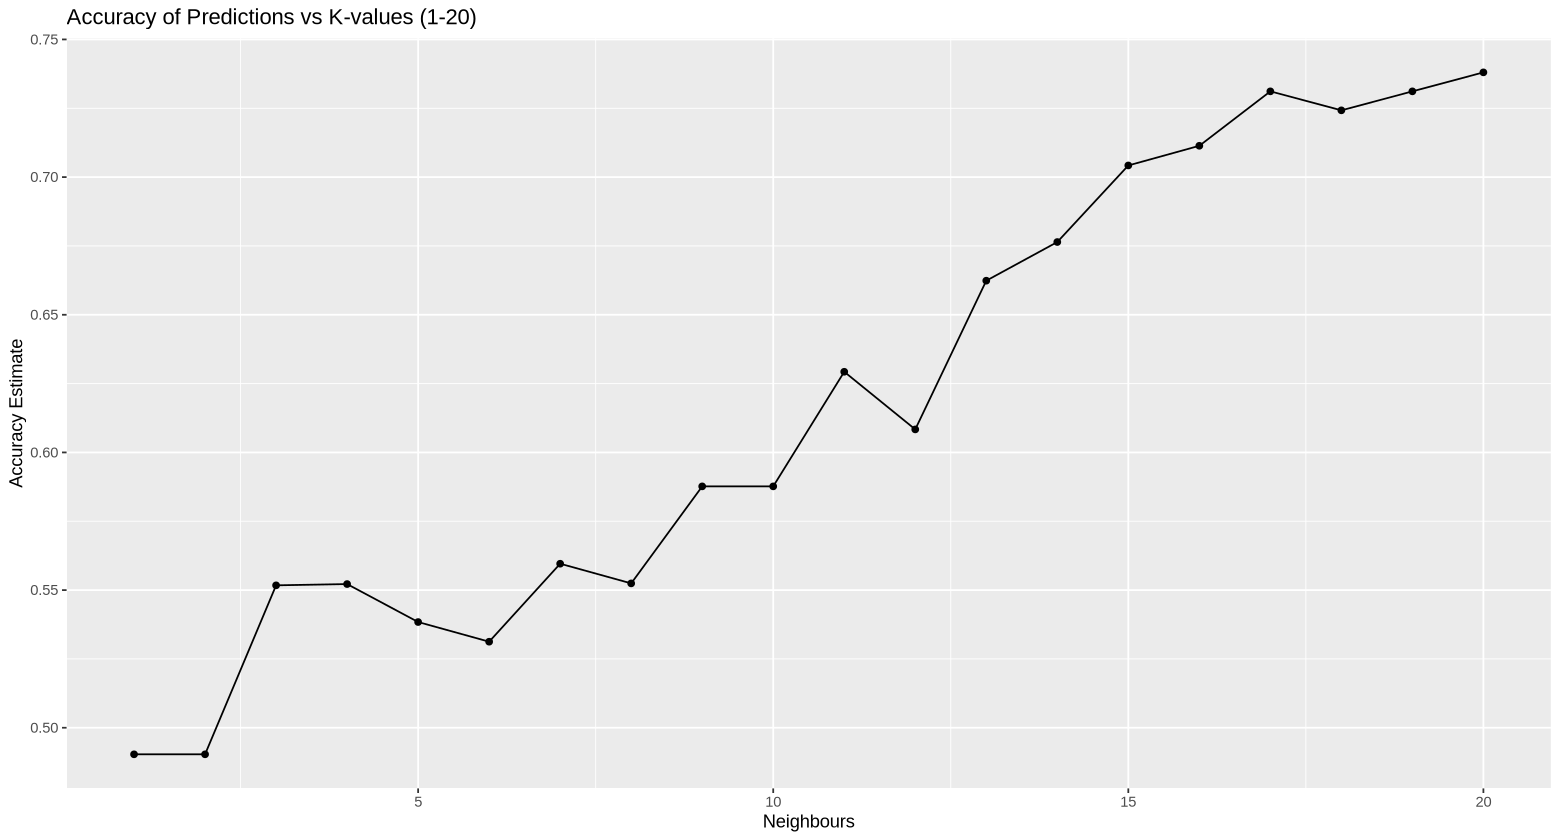

In [13]:
set.seed(1)

k_vals <- tibble(neighbors = c(1:20))
training_10_fold <- vfold_cv(players_train, v = 5, strata = subscribe)
tune_spec <- nearest_neighbor(weight_func = "rectangular", mode = "classification", neighbors = tune()) |> 
                    set_engine("kknn") |> set_mode("classification")

cross_val <- workflow() |> add_recipe(players_recipe) |> add_model(tune_spec) |> 
                        tune_grid(resamples = training_10_fold, grid = k_vals)
cross_val_metrics <- collect_metrics(cross_val)
accuracies <- cross_val_metrics |> filter(.metric == "accuracy") 
cross_val_plot <- accuracies |> ggplot(aes(x = neighbors, y = mean)) + geom_point() + geom_line() +
                                                labs(x = "Neighbours", y = "Accuracy Estimate", title = "Accuracy of Predictions vs K-values (1-20)") 
cross_val_plot
                                                                                                                      

In [14]:
#error from NA in age or hours played. Clean players data to drop NAs.

players_clean <- players |> 
drop_na(Age, played_hours)



# set the seed
set.seed(1)

# creating train / test split
players_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#preprocessing
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

knn_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4482759
Best kernel: rectangular
Best k: 3

In [15]:
#try for v-fold cross validation again

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

training_10_fold <- vfold_cv(players_train, v = 5, strata = subscribe)

tune_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |> 

                set_engine("kknn") |> 
                set_mode("classification")


cross_val <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(tune_spec) |> 



ERROR: Error in parse(text = x, srcfile = src): <text>:19:0: unexpected end of input
17: 
18: 
   ^


In [ ]:
nrow(players)
nrow(players_clean)
nrow(players_train)


In [ ]:
new_data <- 